In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [23]:
def compute_df_soc(df, nominal_Q_Ah, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q_Ah

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q_Ah * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q_Ah, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q_Ah, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1

Train size ≃ 65.92%
Test  size ≃ 34.08%


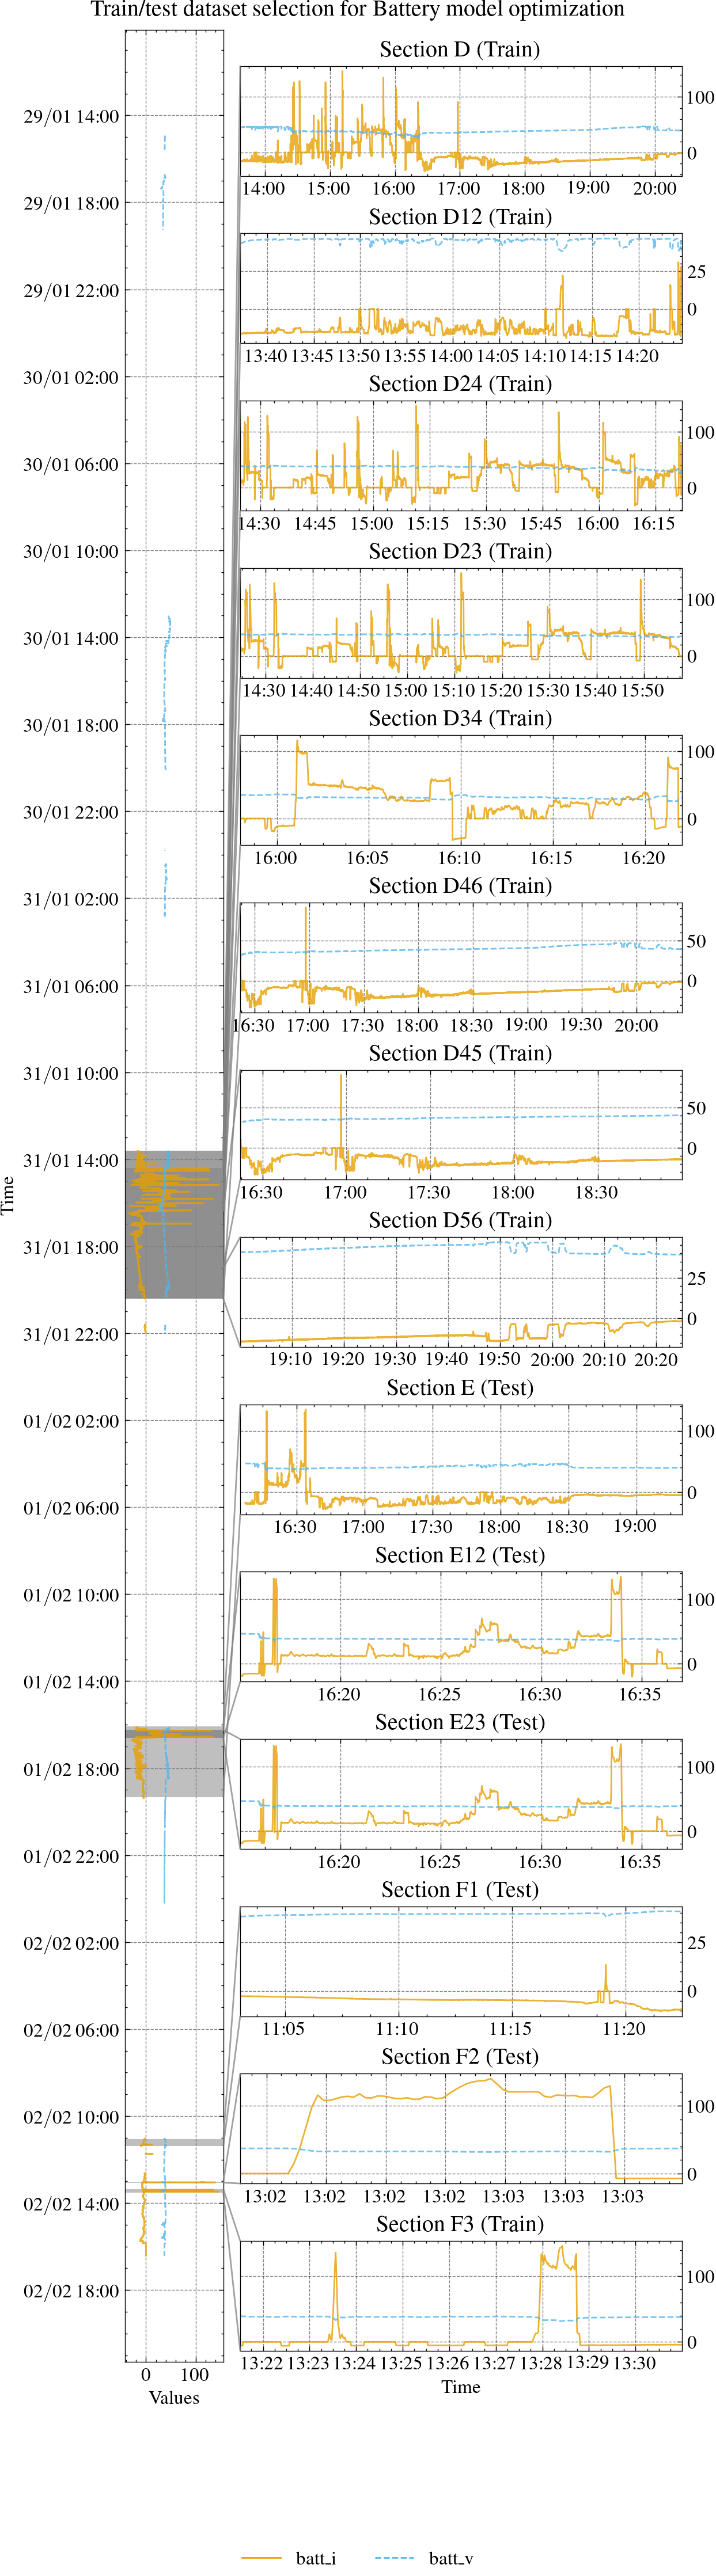

In [24]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q_Ah=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp('2020-01-31 13:37:04')  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp('2020-01-31 14:24:40')  # start of the race
D3 = pd.Timestamp('2020-01-31 15:58:00')  # battery enters in deep-discharge
D4 = pd.Timestamp('2020-01-31 16:22:00')  # race finishes, post-race charge starts
D5 = pd.Timestamp('2020-01-31 19:00:00')  # overcharge starts
D6 = pd.Timestamp('2020-01-31 20:24:55')  # end of the day
sections.loc['Section D'] = [D1, D6]  # Full race event
sections.loc['Section D12'] = [D1, D2]  # Full pre-race charge
sections.loc['Section D24'] = [D2, D4]  # Full race discharge
sections.loc['Section D23'] = [D2, D3]  # Race normal discharge range
sections.loc['Section D34'] = [D3, D4]  # Race deep-discharge range
sections.loc['Section D46'] = [D4, D6]  # Full post-race charge
sections.loc['Section D45'] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc['Section D56'] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 16:05:00'), pd.Timestamp('2020-02-01 19:20:00')] # A quick 15min discharge followed by an overcharge
sections.loc['Section E12'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # A ~15min discharge
sections.loc['Section E23'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # Another over-charging section
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 11:03:00'), pd.Timestamp('2020-02-02 11:22:30')] # A quick charge section
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:02:15'), pd.Timestamp('2020-02-02 13:03:30')] # 2min high-current pulse
sections.loc['Section F3'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:31:00')] # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section E', 'Section E12', 'Section E23', 'Section F1', 'Section F2', 'Section F3']]

train_sections_names = ['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section F3']

train_test_sections = sections.reset_index().to_dict(orient='records')
train_sections = sections.loc[sections.index.intersection(train_sections_names)].reset_index().to_dict(orient='records')
test_sections = sections.loc[sections.index.difference(train_sections_names)].reset_index().to_dict(orient='records')
all_sections = sections.reset_index().to_dict(orient='records')

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask  = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        sec['name'] = sec['name'] + ' (Train)'
        train_mask |= mask
    else:
        sec['name'] = sec['name'] + ' (Test)'
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test  size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
    filename=None,#'{latex_img_path}/battery_optimization_dataset.pdf',
    show_title=f'Train/test dataset selection for Battery model optimization',
    save_title=f'Dataset para treino do modelo da Bateria',
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=['batt_i', 'batt_v'],
        normalize=False,
    )
)

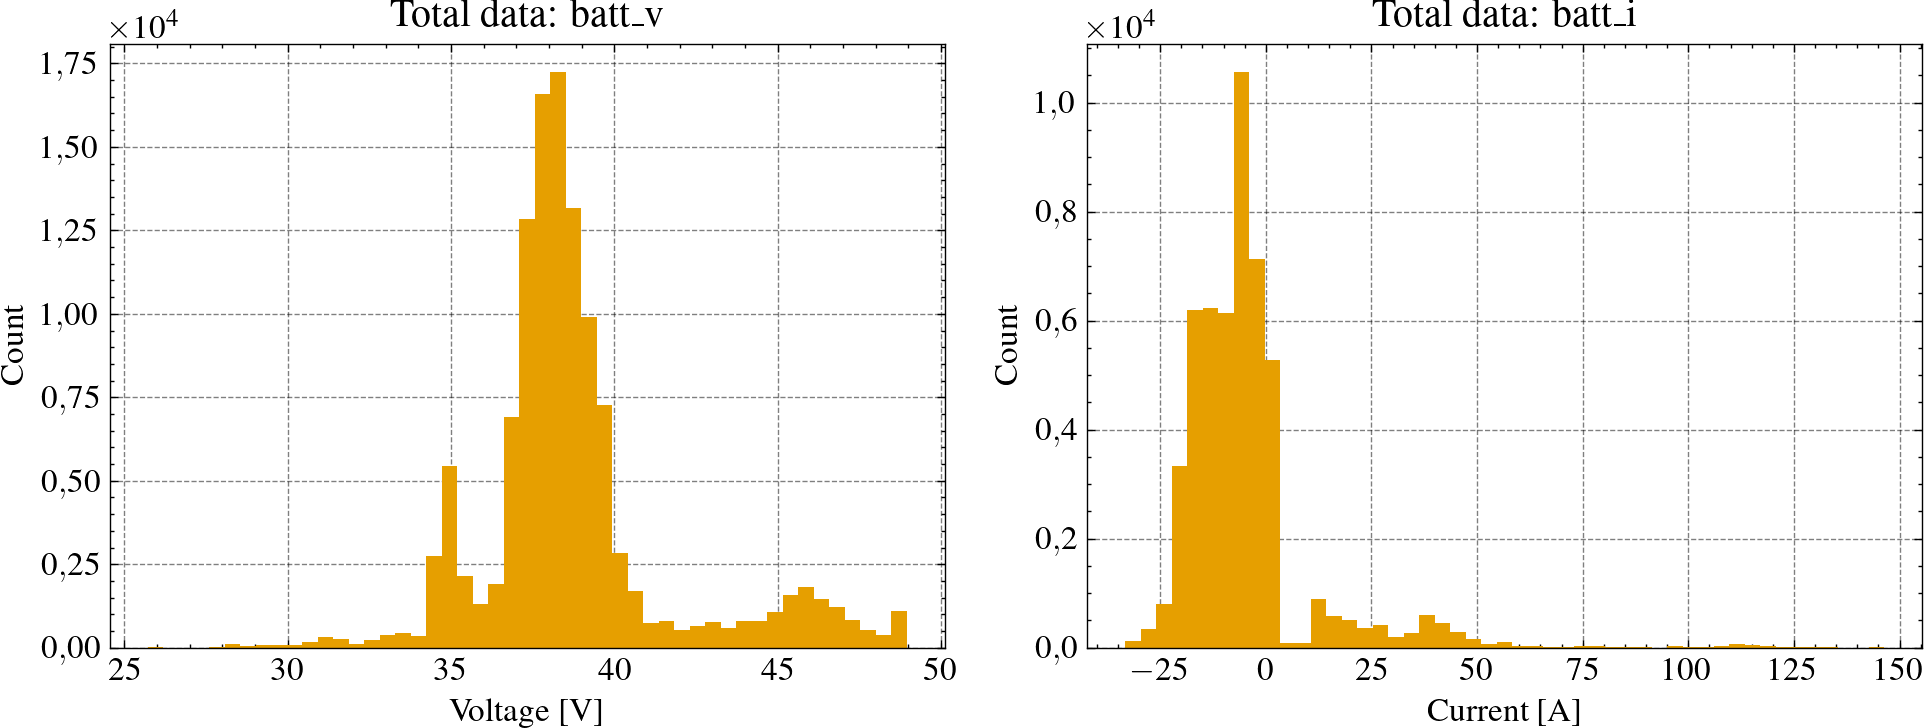

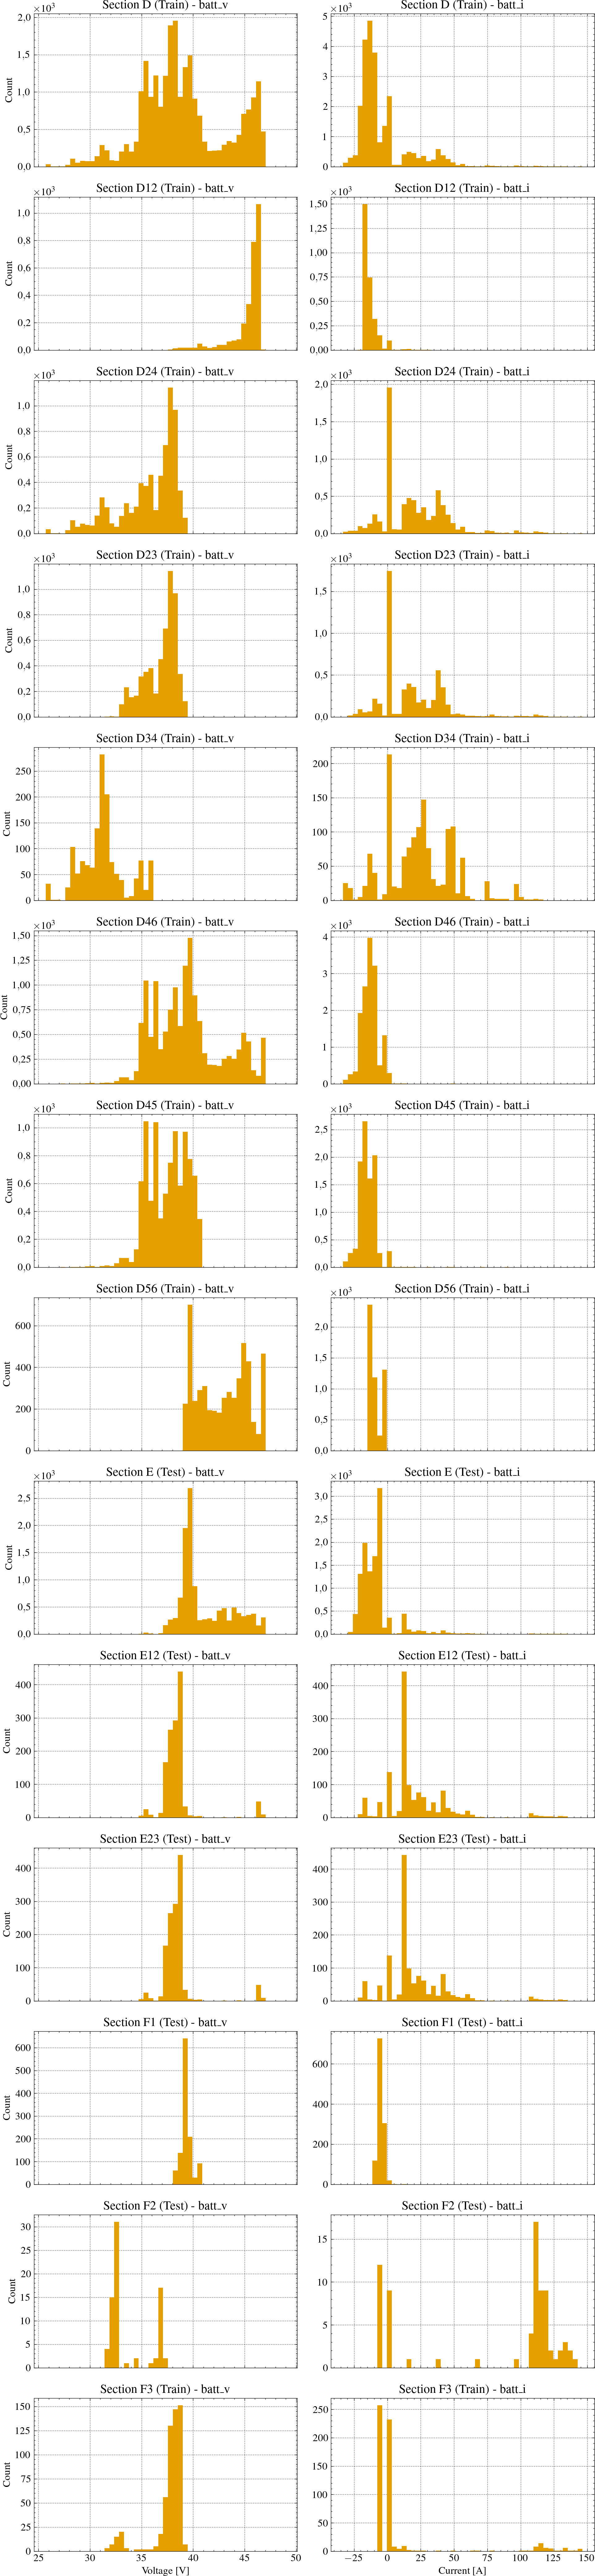

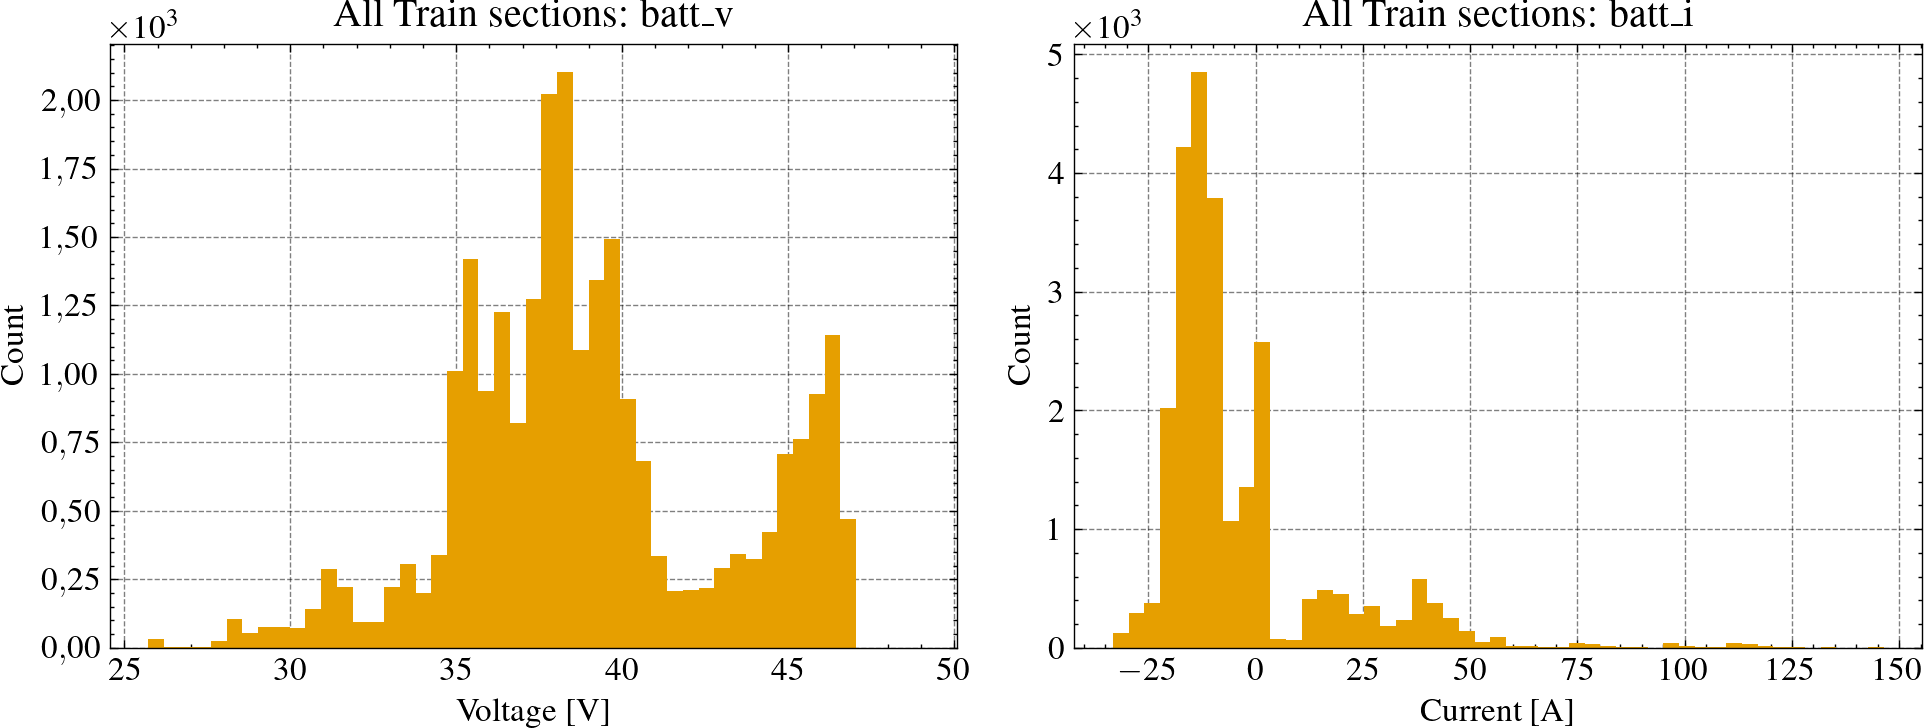

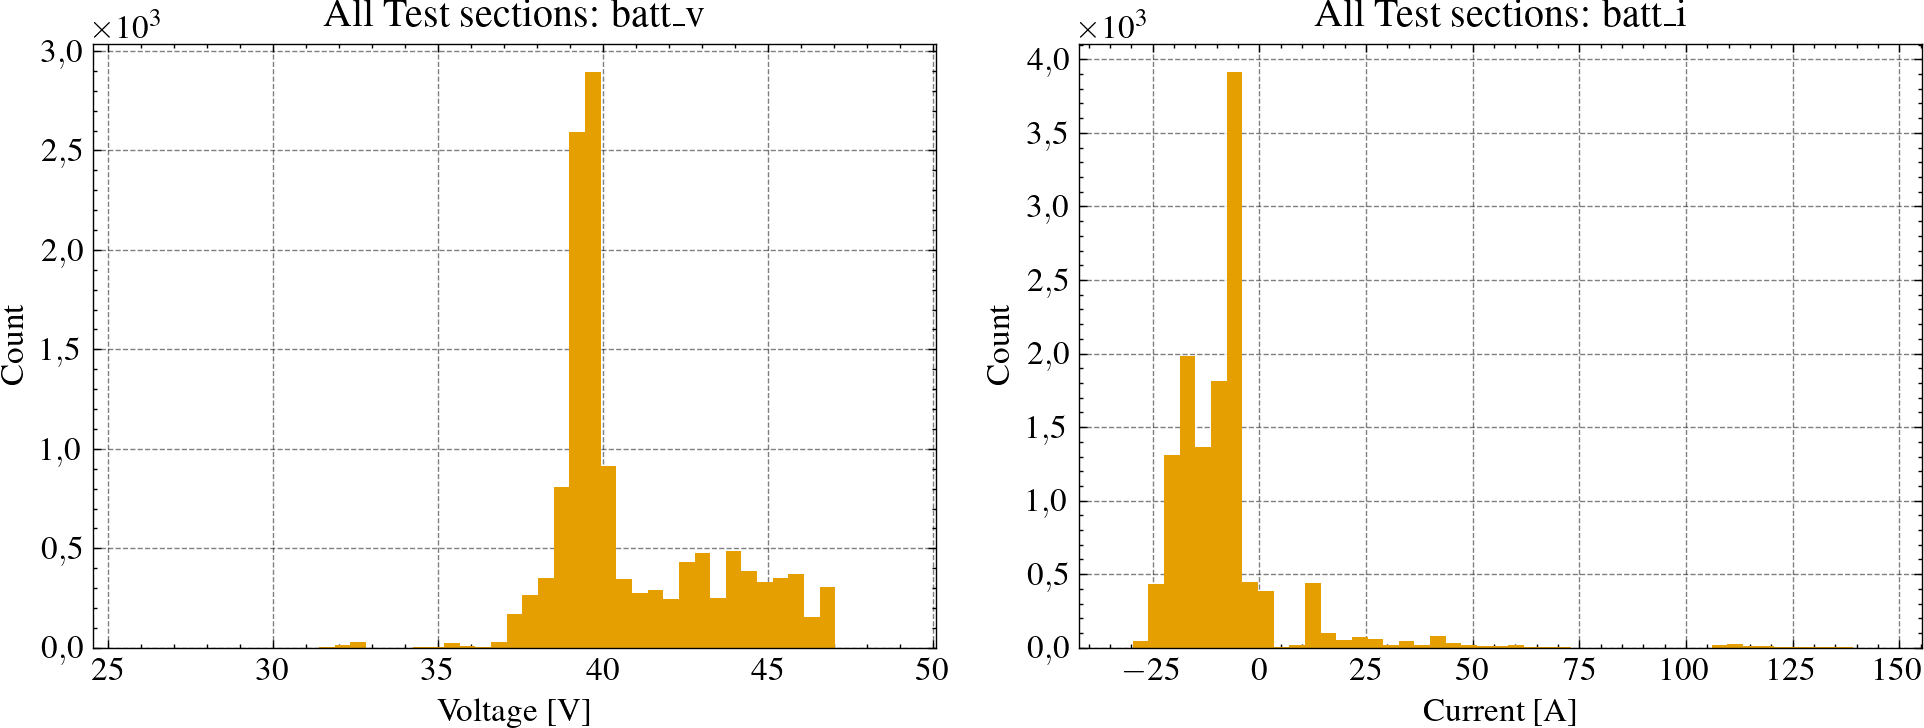

In [25]:
# Dataset Distributions

import numpy as np
import matplotlib.pyplot as plt

# Ensure we have a clean copy of sections with name/start/end
sections_df = sections.reset_index().rename(columns={'index': 'name'})

# Common bins for comparability
v_bins = np.linspace(df['batt_v'].min(), df['batt_v'].max(), 50)
i_bins = np.linspace(df['batt_i'].min(), df['batt_i'].max(), 50)

# ---------------------------------------------------------------------
# 1. Build union masks for train and test (no double-counting overlaps)
# ---------------------------------------------------------------------
train_mask = pd.Series(False, index=df.index)
test_mask = pd.Series(False, index=df.index)

for _, sec in sections_df.iterrows():
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        train_mask |= sec_mask
    else:
        test_mask |= sec_mask

# Optional sanity check: ensure no overlap between final train and test masks
overlap = train_mask & test_mask
if overlap.any():
    print("Warning: some timestamps are in both train and test masks.")

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

# ---------------------------------------------------------------------
# 2. Total dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('Total data: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('Total data: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Per-section histograms (each section, Train/Test split)
# ---------------------------------------------------------------------
n_sections = len(sections_df)
fig, axes = plt.subplots(n_sections, 2, figsize=(10, 3 * n_sections), sharex='col')

if n_sections == 1:
    axes = np.array([axes])  # make it 2D for consistency

for idx, (_, sec) in enumerate(sections_df.iterrows()):
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    dsec = df.loc[sec_mask]

    is_train = sec['name'] in train_sections_names
    label_prefix = 'Train' if is_train else 'Test'
    title = f"{sec['name']} ({label_prefix})"

    # Voltage
    ax_v = axes[idx, 0]
    ax_v.hist(dsec['batt_v'].dropna(), bins=v_bins)
    ax_v.set_title(f"{title} - batt_v")
    ax_v.set_ylabel('Count')
    if idx == n_sections - 1:
        ax_v.set_xlabel('Voltage [V]')

    # Current
    ax_i = axes[idx, 1]
    ax_i.hist(dsec['batt_i'].dropna(), bins=i_bins)
    ax_i.set_title(f"{title} - batt_i")
    if idx == n_sections - 1:
        ax_i.set_xlabel('Current [A]')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4. Aggregated Train dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_train['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Train sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_train['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Train sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5. Aggregated Test dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_test['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Test sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_test['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Test sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()


# Battery PyBAMM Model


In [26]:
import numpy as np
import control as ct
import pybamm


# --------------------------------------------------------------------------- #
#  External → Internal Parameter Mapping                                      #
# --------------------------------------------------------------------------- #

EXTERNAL_TO_PYBAMM = {
    # ---- capacity & geometry -----------------------------------------
    "batt_Q_Ah":       "Nominal cell capacity [A.h]",  # existing
    "batt_cap_neg_vol": "Negative electrode volumetric capacity [C.m-3]",
    "batt_cap_pos_vol": "Positive electrode volumetric capacity [C.m-3]",
    "batt_geom_h":     "Electrode height [m]",
    "batt_geom_w":     "Electrode width [m]",

    # ---- ohmic --------------------------------------------------------
    "batt_R_0":        "Contact resistance [Ohm]",     # existing

    # ---- main kinetics / dynamics ------------------------------------
    "batt_dl_cap_neg": "Negative electrode double-layer capacity [F.m-2]",  # existing
    "batt_dl_cap_pos": "Positive electrode double-layer capacity [F.m-2]",  # existing
    # (if you later expose main reaction i0’s, add them here)
    # "batt_i0_neg":   "Negative electrode exchange-current density [A.m-2]",
    # "batt_i0_pos":   "Positive electrode exchange-current density [A.m-2]",

    # ---- electrolyte / transport -------------------------------------
    "batt_c_e_init":   "Initial concentration in electrolyte [mol.m-3]",     # existing
    "batt_brugg_sep_e": "Separator Bruggeman coefficient (electrolyte)",
    "batt_sigma_neg":  "Negative electrode conductivity [S.m-1]",
    "batt_sigma_pos":  "Positive electrode conductivity [S.m-1]",

    # ---- VRLA gassing / recombination --------------------------------
    "batt_i0_oxy_neg": "Negative electrode reference exchange-current density (oxygen) [A.m-2]",
    "batt_i0_h2_pos":  "Positive electrode reference exchange-current density (hydrogen) [A.m-2]",
    "batt_D_oxy":      "Oxygen diffusivity [m2.s-1]",
    "batt_D_h2":       "Hydrogen diffusivity [m2.s-1]",
    "batt_c_oxy_init": "Initial oxygen concentration [mol.m-3]",           # existing as batt_oc

    # ---- voltage limits / initial state ------------------------------
    "batt_v_min":      "Lower voltage cut-off [V]",                        # existing
    "batt_v_max":      "Upper voltage cut-off [V]",                        # existing
    "batt_z_init":     "Initial State of Charge",                          # alias
    "batt_z":          "Initial State of Charge",                          # existing
    "batt_t_init":     "Initial temperature [K]",                          # alias
    "batt_t":          "Initial temperature [K]",                          # existing

    # ---- thermal ------------------------------------------------------
    "batt_h_total":    "Total heat transfer coefficient [W.m-2.K-1]",
}


def _apply_param_overrides(base_param: pybamm.ParameterValues, flat_params: dict):
    """
    Apply overrides from a flat user dict using EXTERNAL_TO_PYBAMM mapping.
    - Keys in EXTERNAL_TO_PYBAMM are mapped to PyBaMM parameter names.
    - Any other key is assumed to already be a valid PyBaMM name.
    - Only keys that exist in `base_param` are updated.
    """
    new_param = base_param.copy()
    overrides = {}

    for ext_key, value in flat_params.items():
        # Skip non-numeric config keys
        if isinstance(value, str):
            continue

        # Map external name -> internal PyBaMM name if available
        internal_name = EXTERNAL_TO_PYBAMM.get(ext_key, ext_key)

        # Only override if PyBaMM actually knows this parameter
        if internal_name in new_param:
            overrides[internal_name] = float(value)

    if overrides:
        new_param.update(overrides)

    return new_param


def _make_pybamm_bundle(params):
    model = pybamm.lead_acid.LOQS()
    parameter_set = params.get("parameter_set", "Sulzer2019")

    # 2) Base parameters
    if isinstance(parameter_set, pybamm.ParameterValues):
        param = parameter_set
    else:
        param = pybamm.ParameterValues(parameter_set)

    # 3) Apply user overrides
    param = _apply_param_overrides(param, params)

    # 4) Treat current as an input
    param["Current function [A]"] = pybamm.InputParameter("Current function [A]")
    param.process_model(model)

    # 5) Geometry / mesh / discretisation
    geometry = model.default_geometry
    param.process_geometry(geometry)

    mesh = pybamm.Mesh(
        geometry,
        model.default_submesh_types,
        model.default_var_pts,
    )
    disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
    disc.process_model(model)

    # 6) RHS + ICs
    rhs = model.concatenated_rhs
    y0 = np.asarray(model.concatenated_initial_conditions.evaluate(), float).flatten()

    # 7) Output variables
    voltage_var = model.variables["Voltage [V]"]
    soc_var = model.variables.get("State of Charge", None)
    ocv_var = (
        model.variables.get("Open-circuit voltage [V]", None)
        or model.variables.get("Equilibrium voltage [V]", None)
    )

    return {
        "model": model,
        "param": param,
        "rhs": rhs,
        "y0": y0,
        "voltage_var": voltage_var,
        "soc_var": soc_var,
        "ocv_var": ocv_var,
    }

def _sanitize_array(a, nan_value=0.0, max_abs=1e6):
    """
    Ensure a finite float64 array.
    - Replace NaN with nan_value.
    - Replace ±inf with ±max_abs.
    - Clip to [-max_abs, max_abs].
    """
    a = np.asarray(a, float)
    a = np.nan_to_num(a, nan=nan_value, posinf=max_abs, neginf=-max_abs)
    np.clip(a, -max_abs, max_abs, out=a)
    return a


def _safe_scalar(expr, t, x, inputs, default=0.0, clip=None):
    """
    Evaluate a PyBaMM scalar safely:
      - Catch exceptions
      - Replace NaN / ±inf by default
      - Optional clipping
    """
    try:
        val = expr.evaluate(t, x, inputs=inputs)
        v = float(val)
    except Exception:
        return default

    if not np.isfinite(v):
        v = default

    if clip is not None:
        lo, hi = clip
        if lo is not None:
            v = max(lo, v)
        if hi is not None:
            v = min(hi, v)

    return v

# --------------------------------------------------------------------------- #
#   Battery class – flat API everywhere                                      #
# --------------------------------------------------------------------------- #

class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        """
        Use the same flat params dict that build() receives.

        - Start from PyBaMM's default initial conditions.
        - If X0['batt_z'] is provided and a "State of Charge" state exists,
          override all entries of that state with batt_z.

        X0['batt_v'] is ignored here (pack voltage is not a state).
        """
        bundle = _make_pybamm_bundle(params)
        y0 = bundle["y0"].copy()
        soc_var = bundle["soc_var"]
        model = bundle["model"]

        if soc_var is not None and "batt_z" in X0 and hasattr(model, "y_slices"):
            # Find the slice in y corresponding to the SOC variable
            soc_slice = None
            for sym, sl in model.y_slices.items():
                if sym is soc_var:
                    soc_slice = sl
                    break

            if soc_slice is not None:
                z0 = float(X0["batt_z"])
                # y_slices can be a slice or list of slices
                if isinstance(soc_slice, (list, tuple)):
                    for sl in soc_slice:
                        y0[sl] = z0
                else:
                    y0[soc_slice] = z0

        return y0

    @classmethod
    def _update(cls, t, x, u, params: dict):
        bundle = params["pybamm_bundle"]
        rhs = bundle["rhs"]

        I = float(u[0])
        inputs = {"Current function [A]": I}

        dxdt = rhs.evaluate(t, x, inputs=inputs)
        dxdt = _sanitize_array(dxdt, nan_value=0.0, max_abs=1e6)
        return dxdt

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        bundle = params["pybamm_bundle"]
        I = float(u[0])
        inputs = {"Current function [A]": I}

        cells_per_block  = 6
        blocks_in_series = params["batt_N_S"]

        # Reasonable clipping ranges (adjust as needed)
        # Cell voltage: e.g. [-2, 5] V
        V_cell = _safe_scalar(
            bundle["voltage_var"],
            t, x, inputs,
            default=0.0,
            clip=(-2.0, 5.0),
        )
        V = cells_per_block * blocks_in_series * V_cell

        # SoC: allow slight overshoot but keep finite
        if bundle["soc_var"] is not None:
            z = _safe_scalar(
                bundle["soc_var"],
                t, x, inputs,
                default=0.0,
                clip=(-0.2, 1.2),
            )
        else:
            z = 0.0  # finite, safe default

        # OCV: pack-level equivalent; keep sane
        if bundle["ocv_var"] is not None:
            ocv_cell = _safe_scalar(
                bundle["ocv_var"],
                t, x, inputs,
                default=0.0,
                clip=(0.0, 5.0),
            )
            ocv = cells_per_block * blocks_in_series * ocv_cell
        else:
            ocv = 0.0

        return np.array([V, z, ocv], float)
    
    @classmethod
    def build(cls, params: dict):
        bundle = _make_pybamm_bundle(params)

        final_params = params.copy()
        final_params["pybamm_bundle"] = bundle

        n_states = bundle["y0"].size

        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name="battery",
            states=n_states,
            inputs=("batt_i",),
            outputs=("batt_v", "batt_z", "batt_ocv"),
            params=final_params,
        )

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

In [27]:
battery_params_default = dict(pybamm.ParameterValues("Sulzer2019"))
battery_params_default

{'Ideal gas constant [J.K-1.mol-1]': 8.31446261815324,
 'Faraday constant [C.mol-1]': 96485.33212331001,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Electron charge [C]': 1.602176634e-19,
 'Negative current collector thickness [m]': 0.0,
 'Negative electrode thickness [m]': 0.0009,
 'Separator thickness [m]': 0.0015,
 'Positive electrode thickness [m]': 0.00125,
 'Positive current collector thickness [m]': 0.0,
 'Electrode height [m]': 0.114,
 'Electrode width [m]': 0.065,
 'Negative tab width [m]': 0.04,
 'Negative tab centre y-coordinate [m]': 0.06,
 'Negative tab centre z-coordinate [m]': 0.114,
 'Positive tab width [m]': 0.04,
 'Positive tab centre y-coordinate [m]': 0.147,
 'Positive tab centre z-coordinate [m]': 0.114,
 'Cell cooling surface area [m2]': 0.154,
 'Cell volume [m3]': 0.00027,
 'Nominal cell capacity [A.h]': 17.0,
 'Current function [A]': 1.0,
 'Negative current collector density [kg.m-3]': 11300.0,
 'Positive current collector density [kg.m-3]': 9375.0,
 'Negativ

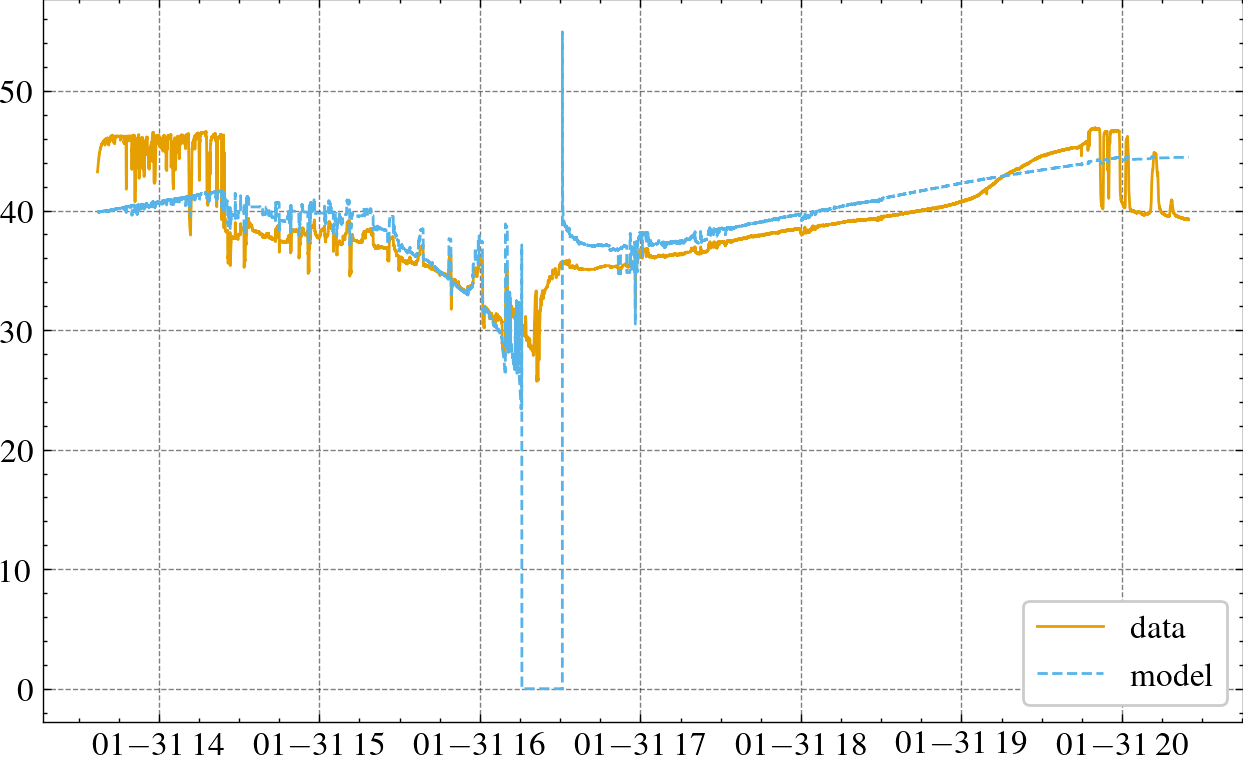

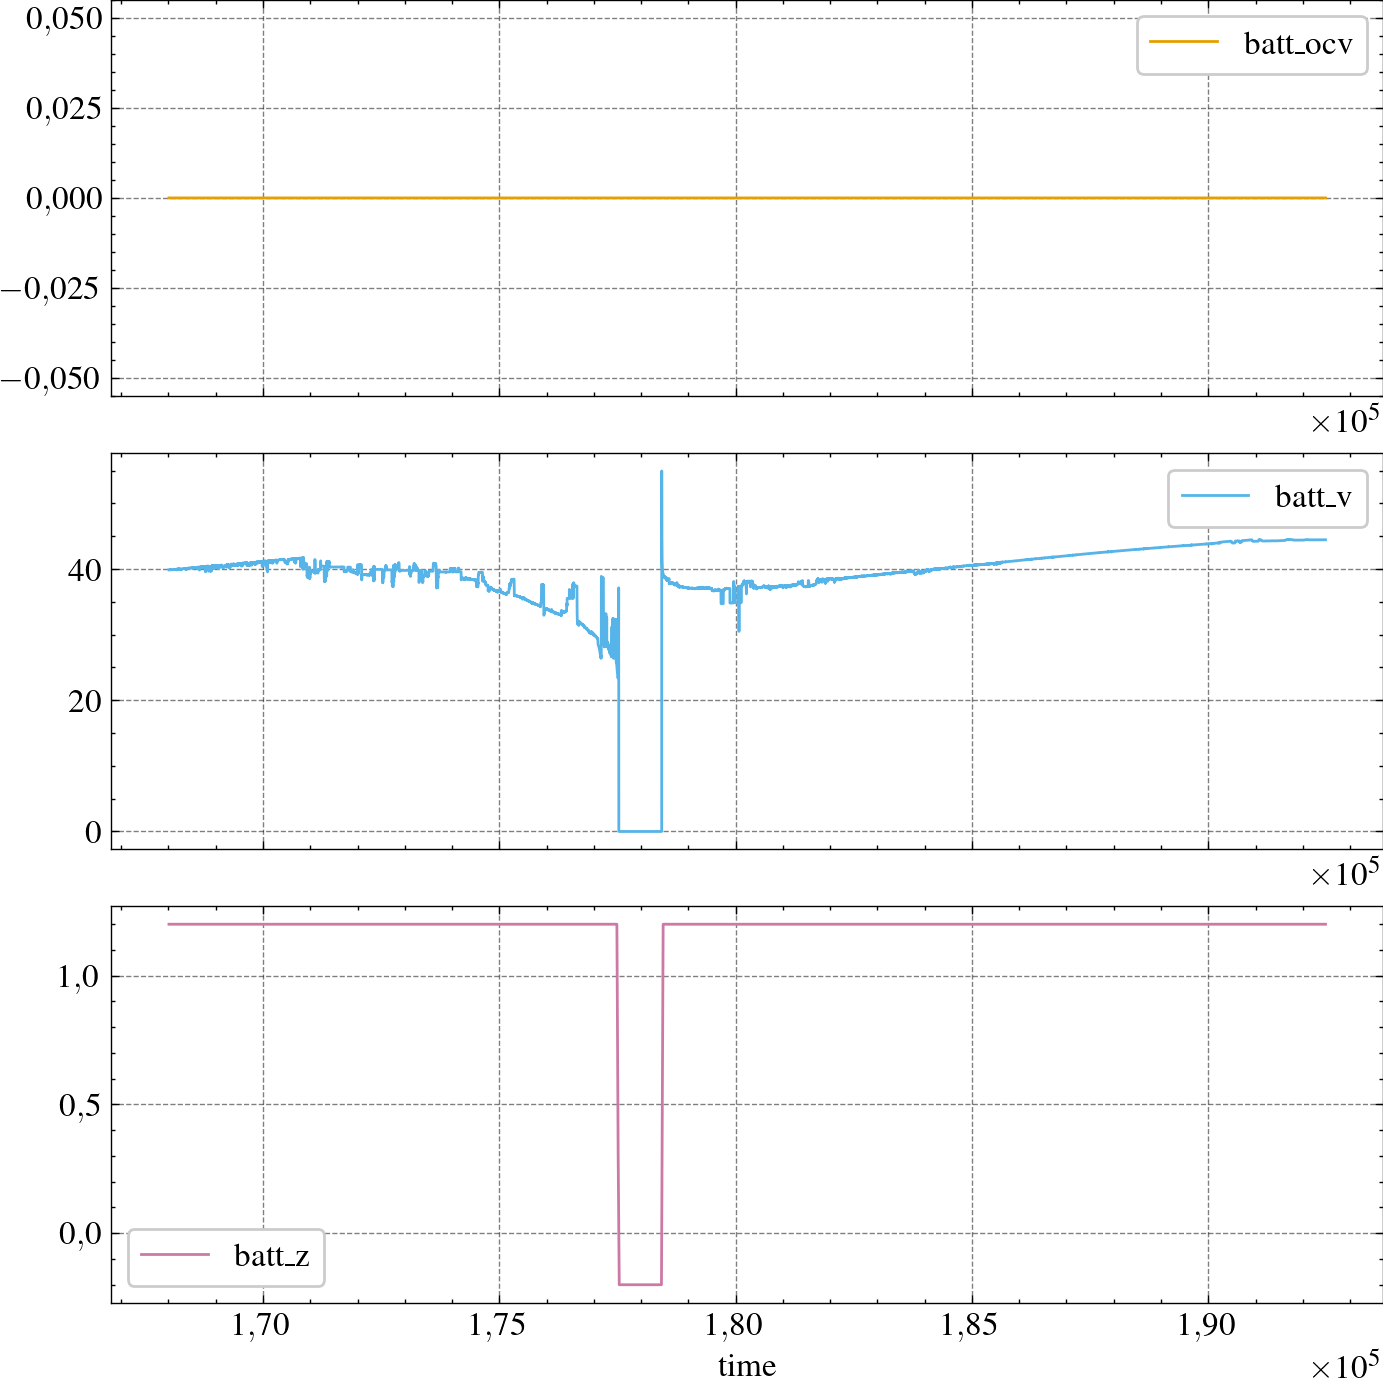

In [28]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q_Ah = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
batt_Q = nominal_Q_Ah * 3600 # [Ah] -> [As]
nominal_voltage = series_cells * cell_voltage
batt_ocv_lut = np.array([10.7865, 10.9583, 11.1160, 11.2607, 11.3937, 11.5161, 11.6292, 11.7343, 11.8324, 11.9249, 12.0129, 12.0976, 12.1803, 12.2622, 12.3444, 12.4283, 12.5150, 12.6056, 12.7016, 12.8039, 12.9139])
initial_SOC = 1

battery_params = {
    # PyBaMM model selection
    "parameter_set": "Sulzer2019",
    "model_kind":   "LOQS",

    # Pack topology / scaling (used only in your wrapper)
    "batt_N_S": series_cells,       # number of 12 V blocks in series (3)

    # ---- capacity & geometry (initial guesses) -----------------------
    # Nominal cell capacity (per 2 V cell). Treat 48 Ah as “nominal” and
    # let the optimizer reconcile with geometric/volumetric capacities.
    "batt_Q_Ah":        nominal_Q_Ah,  # 48.0

    # Start from Sulzer values; let optimization move them.
    "batt_cap_neg_vol": battery_params_default["Negative electrode volumetric capacity [C.m-3]"],
    "batt_cap_pos_vol": battery_params_default["Positive electrode volumetric capacity [C.m-3]"],
    "batt_geom_h":      battery_params_default["Electrode height [m]"],
    "batt_geom_w":      battery_params_default["Electrode width [m]"],

    # ---- ohmic --------------------------------------------------------
    # Slight nonzero contact resistance as a reasonable starting point.
    "batt_R_0":         3e-3,  # [Ohm]

    # ---- main kinetics / dynamics ------------------------------------
    "batt_dl_cap_neg":  battery_params_default["Negative electrode double-layer capacity [F.m-2]"],
    "batt_dl_cap_pos":  battery_params_default["Positive electrode double-layer capacity [F.m-2]"],

    # ---- electrolyte / transport -------------------------------------
    "batt_c_e_init":    battery_params_default["Initial concentration in electrolyte [mol.m-3]"],
    "batt_brugg_sep_e": battery_params_default["Separator Bruggeman coefficient (electrolyte)"],
    "batt_sigma_neg":   battery_params_default["Negative electrode conductivity [S.m-1]"],
    "batt_sigma_pos":   battery_params_default["Positive electrode conductivity [S.m-1]"],

    # ---- VRLA gassing / recombination --------------------------------
    "batt_i0_oxy_neg":  battery_params_default["Negative electrode reference exchange-current density (oxygen) [A.m-2]"],
    "batt_i0_h2_pos":   battery_params_default["Positive electrode reference exchange-current density (hydrogen) [A.m-2]"],
    "batt_D_oxy":       battery_params_default["Oxygen diffusivity [m2.s-1]"],
    "batt_D_h2":        battery_params_default["Hydrogen diffusivity [m2.s-1]"],
    "batt_c_oxy_init":  battery_params_default["Initial oxygen concentration [mol.m-3]"],

    # ---- voltage limits / initial state ------------------------------
    "batt_v_min":       2.0,   # per cell / 2 V equivalent; wrapper scales to pack
    "batt_v_max":       2.42,
    "batt_z_init":      1.0,   # you’re already passing X0['batt_z'] = 1
    "batt_t_init":      battery_params_default["Initial temperature [K]"],

    # ---- thermal ------------------------------------------------------
    "batt_h_total":     battery_params_default["Total heat transfer coefficient [W.m-2.K-1]"],
}

if True:
    # Select the optimization data
    data_cols = ['batt_v']
    input_cols = ['batt_i']
    train_section = train_sections[0]

    df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]#[:7000]

    # Time array
    T = np.ascontiguousarray(df_train['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

    # Model
    battery = Battery.build(battery_params)

    # Initial state
    X0 = Battery.initial_state(
        X0={
            'batt_z': initial_SOC,
            # 'batt_v': df_train['batt_v'].iloc[0],
        },
        U0=U[:,0],
        params=battery_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
    ydata = res.to_pandas().set_index('time')[sorted(list(set(res.output_labels)))]

    plt.figure()
    plt.plot(df_train.index, df_train['batt_v'], label='data')
    plt.plot(df_train.index, ydata['batt_v'], label='model')
    plt.legend(loc='lower right')
    plt.show()

    ydata.plot(subplots=True, figsize=(7,7))
    plt.show()

# Train dataset SOC estimation

In [29]:
def evaluate_soc(df, batt_Q: float,initial_SOC: float, section_name: str, section_decription: str="") -> pd.DataFrame:
    section = next(s for s in all_sections if s['name'] == section_name)
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_section, batt_Q/3600, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q/3600, inplace=True)
    # df_section['batt_z'] = np.clip(df_section['batt_z'], 0, 1)
    
    ending_SOC = float(df_section['batt_z'].iloc[-1])

    print(f'Section {section_name}: SOC went from {initial_SOC} to {ending_SOC}')

    return df_section


In [30]:
# initial_SOC = 1.0
# batt_Q = nominal_Q_Ah * 3600
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# initial_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D1],
#     'Section D12': df_section['batt_z'].loc[D1],
#     'Section D24': df_section['batt_z'].loc[D2],
#     'Section D23': df_section['batt_z'].loc[D2],
#     'Section D34': df_section['batt_z'].loc[D3],
#     'Section D46': df_section['batt_z'].loc[D4],
#     'Section D45': df_section['batt_z'].loc[D4],
#     'Section D56': df_section['batt_z'].loc[D5],
# }
# ending_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D12': df_section['batt_z'].loc[D2],
#     'Section D24': df_section['batt_z'].loc[D4],
#     'Section D23': df_section['batt_z'].loc[D3],
#     'Section D34': df_section['batt_z'].loc[D4],
#     'Section D46': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D45': df_section['batt_z'].loc[D5],
#     'Section D56': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
# }
# display('initial_SOC_dict:', initial_SOC_dict)
# display('ending_SOC_dict:', ending_SOC_dict)

In [31]:
# # TODO: idea: fit Q on full D, 

# # Cleaned params for our sectorized optimization strategy
# initial_params = dict(
#     # Capacity / efficiencies
#     batt_Q      = batt_Q,  # 172800 C per 12 V block
# )

# initial_SOC = 1.0
# batt_Q = 1.0
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# df_section['batt_z'] -= df_section['batt_z'].min()

# df_section[['batt_v', 'batt_z', 'batt_i']].plot(subplots=True, figsize=(7,3))
# plt.show()

# # section_df.loc[D6 - pd.Timedelta('1s')]

# Optimization

In [35]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

# Constraints
from dataclasses import dataclass
from typing import Literal
import numpy as np

ConstraintKind = Literal[
    "simple_order",
    "simple_gap",
    "deep_extra",
    "beta_z_min",
    "beta_z_max",
]

@dataclass
class ParamConstraint:
    """
    Generic constraint usable by pymoo: g(x) <= 0 when satisfied.
    Picklable, works with multiprocessing.
    """
    kind: ConstraintKind

    # indices into the decision vector x
    idx_a: int | None = None
    idx_b: int | None = None
    idx_c: int | None = None  # third index if needed (e.g. z_deep)

    # generic scalars for constraints
    gap: float = 1.0          # used by simple_gap
    limit: float = 0.0        # used by deep_extra, beta_z_min/max

    def __call__(self, x: np.ndarray) -> float:
        if self.kind == "simple_gap":
            # tau_b >= gap * tau_a -> gap*tau_a - tau_b <= 0
            return self.gap * x[self.idx_a] - x[self.idx_b]

        if self.kind == "simple_order":
            # R_a < R_b -> R_a - R_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "deep_extra":
            # deep-discharge extra "ohms" at z ~ 0:
            #   R_extra = R0_deep + k_deep * max(0, z_deep)
            # constraint: R_extra <= limit  -> R_extra - limit <= 0
            R0_deep = x[self.idx_a]
            k_deep  = x[self.idx_b]
            z_deep  = x[self.idx_c]
            R_extra = R0_deep + k_deep * max(0.0, z_deep)
            return R_extra - self.limit

        if self.kind == "beta_z_min":
            # beta * z_deep >= limit  -> limit - beta*z <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return self.limit - beta * z_deep

        if self.kind == "beta_z_max":
            # beta * z_deep <= limit  -> beta*z - limit <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return beta * z_deep - self.limit

        return 0.0

class BatteryWithSocOptimizationProblem(ElementwiseProblem):
    def __init__(
        self,
        model,
        model_function,
        training_data,
        training_data_columns,
        model_params,
        opt_params_bounds,
        input_columns,
        data_scaler=RobustScaler,
        constraint_funcs=None,
        print_exceptions=False,
        **kwargs,
    ):
        assert all(
            "min" in pb and "max" in pb for pb in opt_params_bounds.values()
        ), "All opt_params_bounds must have 'min' and 'max' keys"

        self.model = model
        self.model_function = model_function
        self.model_params = model_params
        self.data_scaler_cls = data_scaler
        self.training_data_columns = training_data_columns  # e.g. ['batt_v', 'batt_z']
        self.opt_param_names = list(opt_params_bounds.keys())
        self.input_columns = input_columns
        self.print_exceptions = print_exceptions
        self.constraint_funcs = constraint_funcs or []

        # Keep the raw training data (no batt_z yet)
        self.training_data_raw = training_data.copy(deep=True)

        # Time vector
        self.T = np.ascontiguousarray(training_data['t'].to_numpy())

        # Inputs
        self.U = np.ascontiguousarray(training_data[input_columns].to_numpy().T)

        # --- Fit scaler once using a baseline initial_SOC0 (e.g. 0.5) ---
        df0 = self.training_data_raw.copy()
        initial_SOC0 = 0.5
        batt_Q_Ah = self.model_params['batt_Q_Ah']
        compute_df_capacity(df0, batt_Q_Ah, initial_SOC0, inplace=True)
        compute_df_soc(df0, batt_Q_Ah, inplace=True)
        Y0 = df0[self.training_data_columns].to_numpy()
        self.data_scaler = self.data_scaler_cls().fit(Y0)

        super().__init__(
            n_var=len(self.opt_param_names),
            n_obj=1,
            n_constr=len(self.constraint_funcs),
            xl=np.array([p["min"] for p in opt_params_bounds.values()]),
            xu=np.array([p["max"] for p in opt_params_bounds.values()]),
            **kwargs,
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.objective_function(x, *args, **kwargs)

        if self.constraint_funcs:
            # Each constraint func should return a scalar ≤ 0 when satisfied
            g = [func(x) for func in self.constraint_funcs]
            out["G"] = np.array(g)

    def objective_function(self, x, *args, **kwargs):
        # Map decision vector to parameters
        params_dict = {name: x[i] for i, name in enumerate(self.opt_param_names)}
        initial_SOC = params_dict.pop('batt_z')
        model_params = self.model_params | convert_to_model_params(params_dict)
        batt_Q_Ah = model_params['batt_Q_Ah']

        # Recompute SOC trajectory from candidate batt_z_0
        df_temp = self.training_data_raw.copy()
        compute_df_capacity(df_temp, batt_Q_Ah, initial_SOC, inplace=True)
        compute_df_soc(df_temp, batt_Q_Ah, inplace=True)

        # Ground truth (voltage + SOC) for this candidate
        y_true = df_temp[self.training_data_columns].to_numpy()
        scaled_y_true = self.scale_data(y_true)

        # Initial state
        X0 = self.model.initial_state(
            X0={
                'batt_z': df_temp['batt_z'].iloc[0],
                'batt_v': df_temp['batt_v'].iloc[0],
            },
            U0=self.U[:, 0],
            params=model_params,
        )

        # Run the simulation
        try:
            model_predictions = self.model_function(
                T=self.T, U=self.U, X0=X0, **model_params
            )[self.training_data_columns].to_numpy()
        except Exception as e:
            if self.print_exceptions:
                print(f"Exception from model_function: {e}")
            return 1e9  # Penalize parameters that break the model

        # Scale model predictions
        scaled_model_predictions = self.scale_data(model_predictions)

        return mean_squared_error(scaled_y_true, scaled_model_predictions)

    def scale_data(self, data):
        return self.data_scaler.transform(data)

    def rescale_data(self, data):
        return self.data_scaler.inverse_transform(data)

def run_battery_optimization(
    model,
    model_params: dict,
    section_name: str,
    params_bounds: dict,
    initial_SOC: float,
    df,
    constraint_funcs: list,
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=20,
):
    train_section = next(s for s in train_sections if s['name'] == section_name)
    print(''.join(['=']*100))
    print('\n\nTraining on section:', section_name)

    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

        # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')

    lut_coeffs = [
        # {'name': 'batt_ocv_lut', 'lut_size': 21, 'bounds': (10.5, 13.5)},
    ]
    for coeff in lut_coeffs:
        name = coeff['name']
        values_bounds = coeff['bounds']
        lut_size = coeff['lut_size']
        for i in range(0, lut_size):
            params_bounds[f'{name}_{i}'] = dict(min=values_bounds[0], max=values_bounds[1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    try:
        # Set up the optimization problem
        if 'batt_z' in params_bounds:
            problem = BatteryWithSocOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )
        else:
            # Compute battery capacity and SOC using the hyperparameter initial_SOC
            batt_Q_Ah = model_params['batt_Q_Ah']
            compute_df_capacity(df_train, batt_Q_Ah, initial_SOC, inplace=True)
            compute_df_soc(df_train, batt_Q_Ah, inplace=True)

            # Initial state
            input_initial_state = dict(
                batt_z=df_train['batt_z'].iloc[0],
                batt_v=df_train['batt_v'].iloc[0],
            )

            problem = MyOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_initial_state=input_initial_state,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )

        # Configure the optimization algorithm (Differential Evolution in this case)
        algorithm = DE(
            pop_size=algorithm_pop_size_k * len(params_bounds),
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )
        # algorithm = CMAES(
        #     pop_size=32,     # 16–64 is typical
        #     sigma=0.3        # initial step size in normalized space
        # )

        # Set termination criteria
        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=termination_period,
            n_max_gen=10000,
            n_max_evals=1000000,
        )

        # Run the optimization
        result = minimize(
            problem,
            algorithm,
            termination=termination,
            seed=42,
            verbose=True,
            save_history=True,
        )
    finally:
        pool.close()
        pool.join()

    # Retrieve and display the best parameters
    raw_params = {k: result.X[i] for i, k in enumerate(params_bounds.keys())}
    best_params = convert_to_model_params(raw_params)
    original_params = {k: convert_to_model_params(model_params).get(k) for k in best_params.keys()}
    print("Original parameters were:")
    display(original_params)
    print("Best parameters found:")
    display(best_params)
    print("Objective value at solution:", result.F)

    # Plot optimization results
    if plot_results:
        plot_optimization_params(result, params_bounds)
        plot_optimization_error(result)

    initial_SOC_opt = best_params.get("batt_z", initial_SOC)
    batt_Q_Ah  = (model_params | best_params)['batt_Q_Ah']

    # Simulate the model with the optimized parameters
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_train, batt_Q_Ah, initial_SOC_opt, inplace=True)
    compute_df_soc(df_train, batt_Q_Ah, inplace=True)
    T = np.ascontiguousarray(df_train['t'].to_numpy())
    U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
    X0 = Battery.initial_state(
        X0={
            'batt_z': df_train['batt_z'].iloc[0],
            'batt_v': df_train['batt_v'].iloc[0],
        },
        U0=U[:, 0],
        params=model_params | best_params
    )
    best_fit_data = model_function(T, U, X0, **(model_params | best_params))
    ending_SOC = best_fit_data['batt_z'].iloc[-1]

    if plot_simulation:
        # Plot the comparison for each data column
        for col in data_cols:
            plot_compare(df_train, best_fit_data, col)

    return result, params_bounds, best_params, ending_SOC

def check_fit(section_name, model_params, initial_SOC):
    batt_Q_Ah = model_params['batt_Q_Ah']
    section = next(s for s in all_sections if s['name'] == section_name)

    data_cols = ['batt_v']
    input_cols = ['batt_i']
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols]
    compute_df_capacity(df_section, batt_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q_Ah, inplace=True)

    # Time array
    T = np.ascontiguousarray(df_section['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_section[input_cols].to_numpy().T)

    # Model
    battery = Battery.build(model_params)

    # Initial state
    X0 = Battery.initial_state(
        X0={
            'batt_z': initial_SOC,
            'batt_v': df_section['batt_v'].iloc[0],
        },
        U0=U[:,0],
        params=model_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
    ydata = res.to_pandas().set_index('time')[sorted(data_cols)]

    for column in ydata.columns:
        plot_compare(df_section, ydata, column, show=True)

In [33]:
initial_params = battery_params.copy()



Training on section: Section D
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      190 |  0.1494907221 |  0.0141279820
     2 |      380 |  0.0749626295 |  0.0141279820
     3 |      570 |  0.0368165475 |  0.0139902781
     4 |      760 |  0.0238276107 |  0.0134439559
     5 |      950 |  0.0205349752 |  0.0134439559
     6 |     1140 |  0.0187338750 |  0.0133426216
     7 |     1330 |  0.0176577118 |  0.0133426216
     8 |     1520 |  0.0166279827 |  0.0126796247
     9 |     1710 |  0.0159679377 |  0.0126796247
    10 |     1900 |  0.0154541581 |  0.0126796247
    11 |     2090 |  0.0150921996 |  0.0126796247
    12 |     2280 |  0.0147286938 |  0.0126796247
    13 |     2470 |  0.0144558494 |  0.0126796247
    14 |     2660 |  0.0142781025 |  0.0126796247
    15 |     2850 |  0.0141081405 |  0.0126796247
    16 |     3040 |  0.0139858513 |  0.0126796247
    17 |     3230 |  0.0139086382 |  0.0126796247
    18 |     3420 |  0.0138344854 |  0.0126796247
    19 |     3610

{'batt_Q_Ah': 48,
 'batt_cap_neg_vol': 3473000000.0,
 'batt_cap_pos_vol': 2745000000.0,
 'batt_geom_h': 0.114,
 'batt_geom_w': 0.065,
 'batt_R_0': 0.003,
 'batt_dl_cap_neg': 0.2,
 'batt_dl_cap_pos': 0.2,
 'batt_c_e_init': 5650.0,
 'batt_brugg_sep_e': 1.5,
 'batt_sigma_neg': 4800000.0,
 'batt_sigma_pos': 80000.0,
 'batt_i0_oxy_neg': 2.5e-32,
 'batt_i0_h2_pos': 0.0,
 'batt_D_oxy': 2.1e-09,
 'batt_D_h2': 4.5e-09,
 'batt_c_oxy_init': 0.0,
 'batt_h_total': 10.0,
 'batt_z': None}

Best parameters found:


{'batt_Q_Ah': 30.32795514067064,
 'batt_cap_neg_vol': 1128378090.5943632,
 'batt_cap_pos_vol': 3984813219.406308,
 'batt_geom_h': 0.07662033304085437,
 'batt_geom_w': 0.12223369542839813,
 'batt_R_0': 0.017425206154415784,
 'batt_dl_cap_neg': 0.33913693023349667,
 'batt_dl_cap_pos': 0.22464697059861677,
 'batt_c_e_init': 5701.139114991836,
 'batt_brugg_sep_e': 2.232101030573642,
 'batt_sigma_neg': 13652749.995840553,
 'batt_sigma_pos': 80613.77901682229,
 'batt_i0_oxy_neg': 1.3881389321169495e-32,
 'batt_i0_h2_pos': 0.0,
 'batt_D_oxy': 2.135618470589409e-09,
 'batt_D_h2': 9.009463575360762e-09,
 'batt_c_oxy_init': 0.5310724778701784,
 'batt_h_total': 9.195520148573987,
 'batt_z': 0.9371753083417138}

Objective value at solution: [0.01255078]


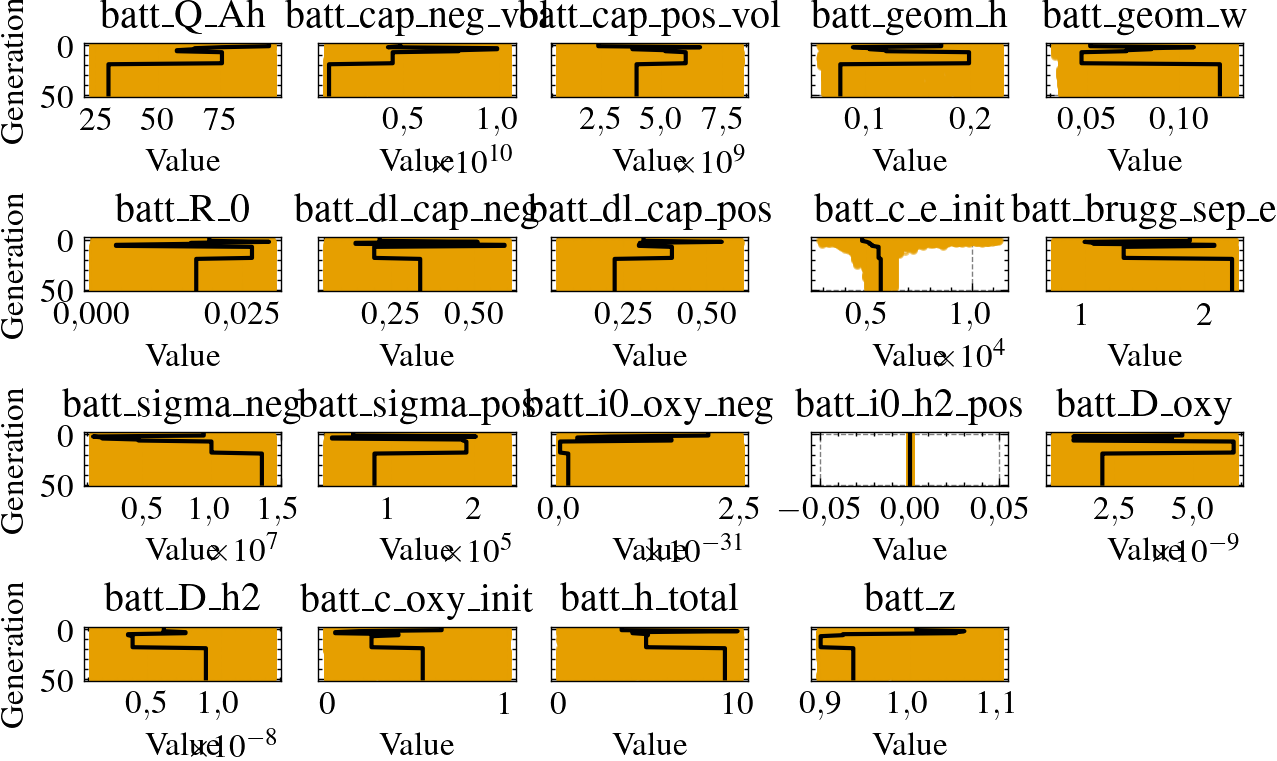

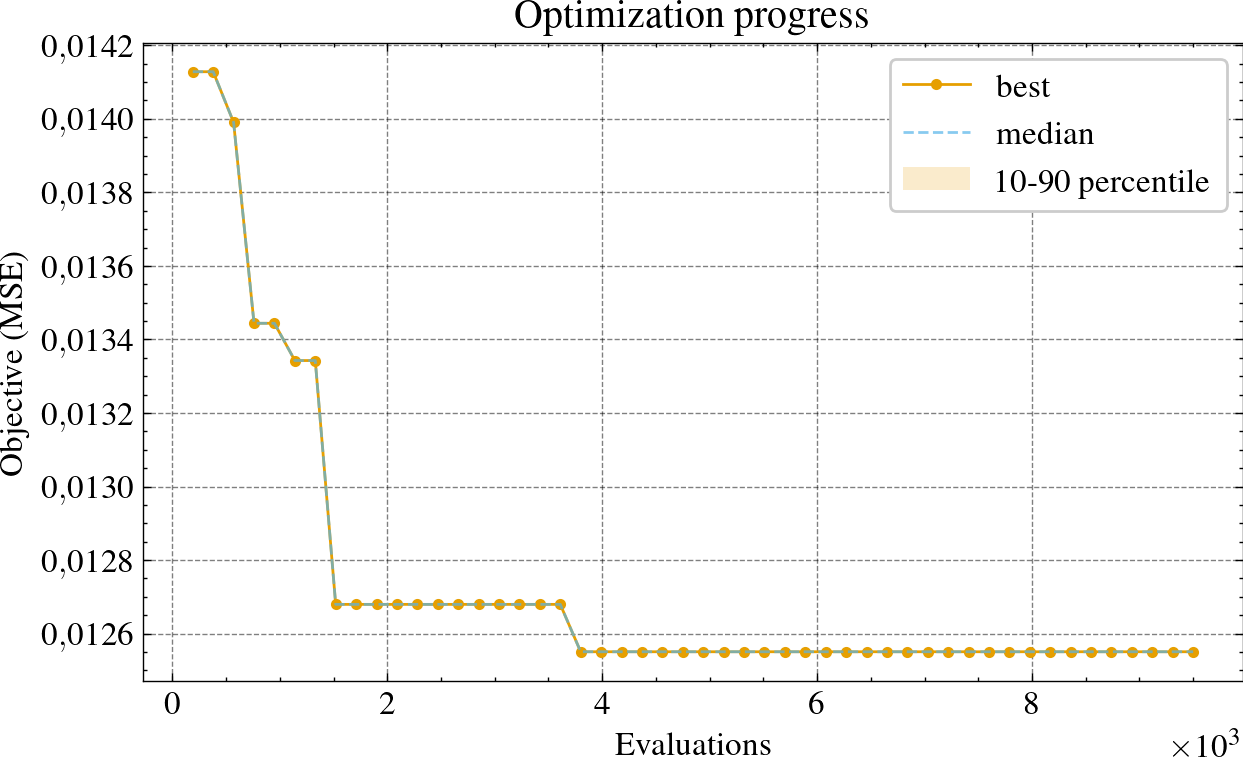

KeyError: 'batt_Q'

In [34]:
%%time

def build_ECM_constraints(params_bounds: dict) -> list[ParamConstraint]:
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    # cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_0'], idx_b=idx['batt_R_1']))  # R0 < R1
    # cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_1'], idx_b=idx['batt_R_2']))  # R1 < R2
    # cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_C_1'], idx_b=idx['batt_C_2']))  # C1 < C2
    # cons.append(ParamConstraint(kind="simple_gap", idx_a=idx['batt_C_1'], idx_b=idx['batt_C_2'], gap=10))  # C2 >= 10*C1

    return cons

model_params_D = initial_params.copy()
initial_SOC_D = 1
params_bounds_D = dict(
    # ---- capacity & geometry ---------------------------------------------
    batt_Q_Ah=dict(        min=0.5*model_params_D["batt_Q_Ah"],        max=2.0*model_params_D["batt_Q_Ah"]),   # 24–96 Ah),
    batt_cap_neg_vol=dict( min=0.3*model_params_D["batt_cap_neg_vol"], max=3.0*model_params_D["batt_cap_neg_vol"]),
    batt_cap_pos_vol=dict( min=0.3*model_params_D["batt_cap_pos_vol"], max=3.0*model_params_D["batt_cap_pos_vol"]),
    batt_geom_h=dict(      min=0.5*model_params_D["batt_geom_h"],      max=2.0*model_params_D["batt_geom_h"]),
    batt_geom_w=dict(      min=0.5*model_params_D["batt_geom_w"],      max=2.0*model_params_D["batt_geom_w"]),

    # ---- ohmic -----------------------------------------------------------
    batt_R_0=dict(         min=0.1*model_params_D["batt_R_0"],         max=10.0*model_params_D["batt_R_0"]),

    # ---- kinetics / dynamics --------------------------------------------
    batt_dl_cap_neg=dict(  min=0.3*model_params_D["batt_dl_cap_neg"],  max=3.0*model_params_D["batt_dl_cap_neg"]),
    batt_dl_cap_pos=dict(  min=0.3*model_params_D["batt_dl_cap_pos"],  max=3.0*model_params_D["batt_dl_cap_pos"]),

    # ---- electrolyte / transport ----------------------------------------
    batt_c_e_init=dict(    min=0.5*model_params_D["batt_c_e_init"],    max=2.0*model_params_D["batt_c_e_init"]),
    batt_brugg_sep_e=dict( min=0.5*model_params_D["batt_brugg_sep_e"], max=1.5*model_params_D["batt_brugg_sep_e"]),
    batt_sigma_neg=dict(   min=0.3*model_params_D["batt_sigma_neg"],   max=3.0*model_params_D["batt_sigma_neg"]),
    batt_sigma_pos=dict(   min=0.3*model_params_D["batt_sigma_pos"],   max=3.0*model_params_D["batt_sigma_pos"]),

    # ---- VRLA gassing / recombination -----------------------------------
    batt_i0_oxy_neg=dict(  min=0.1*model_params_D["batt_i0_oxy_neg"],  max=10.0*model_params_D["batt_i0_oxy_neg"]),
    batt_i0_h2_pos=dict(   min=0.1*model_params_D["batt_i0_h2_pos"],   max=10.0*model_params_D["batt_i0_h2_pos"]),
    batt_D_oxy=dict(       min=0.3*model_params_D["batt_D_oxy"],       max=3.0*model_params_D["batt_D_oxy"]),
    batt_D_h2=dict(        min=0.3*model_params_D["batt_D_h2"],        max=3.0*model_params_D["batt_D_h2"]),
    # Oxygen can go from 0 (no stored O2) up to much larger than default
    batt_c_oxy_init=dict(  min=0.0,max=max(10.0 * battery_params["batt_c_oxy_init"], 1.0)),

    # ---- thermal ---------------------------------------------------------
    batt_h_total=dict(     min=0.1, max=10.0),

    # Optional: initial condition bounds
    batt_z        = dict(min=0.9,  max=1.10),    # initial SOC
)

# Train w/ normal region
result_D, params_bounds_D, best_params_D, ending_SOC_D = run_battery_optimization(
    model=Battery,
    model_params=model_params_D,
    initial_SOC=initial_SOC_D,
    section_name='Section D',
    df=df,
    params_bounds=params_bounds_D,
    constraint_funcs=build_ECM_constraints(params_bounds_D),
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=30,
)

check_fit(model_params=model_params_D | best_params_D)

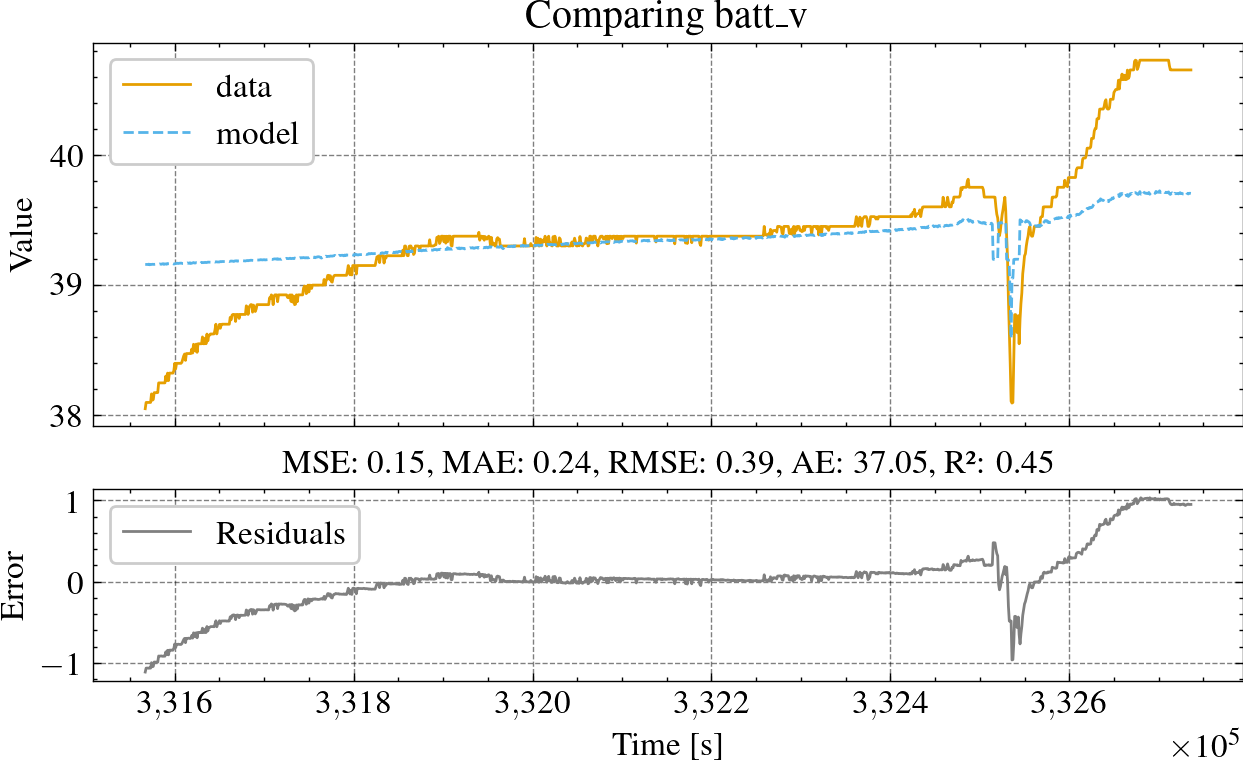

In [52]:
best_params_D = {'batt_Q_Ah': 30.32795514067064,
 'batt_cap_neg_vol': 1128378090.5943632,
 'batt_cap_pos_vol': 3984813219.406308,
 'batt_geom_h': 0.07662033304085437,
 'batt_geom_w': 0.12223369542839813,
 'batt_R_0': 0.017425206154415784,
 'batt_dl_cap_neg': 0.33913693023349667,
 'batt_dl_cap_pos': 0.22464697059861677,
 'batt_c_e_init': 5701.139114991836,
 'batt_brugg_sep_e': 2.232101030573642,
 'batt_sigma_neg': 13652749.995840553,
 'batt_sigma_pos': 80613.77901682229,
 'batt_i0_oxy_neg': 1.3881389321169495e-32,
 'batt_i0_h2_pos': 0.0,
 'batt_D_oxy': 2.135618470589409e-09,
 'batt_D_h2': 9.009463575360762e-09,
 'batt_c_oxy_init': 0.5310724778701784,
 'batt_h_total': 9.195520148573987,
 'batt_z': 0.9371753083417138}

best_params_D['batt_z'] = 1
check_fit(section_name='Section F1', initial_SOC=best_params_D['batt_z'], model_params=model_params_D | best_params_D)
